# Project: Movie Data Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> This is a report about an investigation of a data set containing information about movies using python with pandas and jupyter notebook.

> Dataset used is: tmdb-movies.csv

> Following questions should be answered:

1. Most profitable movie absolute and corrected for inflation

2. Which genres are most produced from year to year?

3. Director with most popular films


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

<a id='wrangling'></a>
## Data Wrangling


### General Properties
> First load the data from csv file

In [2]:
df = pd.read_csv('tmdb-movies.csv')
df.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09


> Now that the data is imported, lets see how big is the data set:

In [3]:
df.shape

(10866, 21)

> Rows and columns of the data set to get a very basic idea of the data set

> Now let us see some info about the data and if there is anything missing.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

> Some data is missing for some columns. For example "homepage".

> Some rows like id are not needed because they are not relevant for this statisic investigation

> Next we will get detailed info about the numeric data:

In [5]:
df.describe()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,10866.000000,10866.000000,1.086600e+04,1.086600e+04,10866.000000,10866.000000,10866.000000,10866.000000,1.086600e+04,1.086600e+04
mean,66064.177434,0.646441,1.462570e+07,3.982332e+07,102.070863,217.389748,5.974922,2001.322658,1.755104e+07,5.136436e+07
std,92130.136561,1.000185,3.091321e+07,1.170035e+08,31.381405,575.619058,0.935142,12.812941,3.430616e+07,1.446325e+08
min,5.000000,0.000065,0.000000e+00,0.000000e+00,0.000000,10.000000,1.500000,1960.000000,0.000000e+00,0.000000e+00
25%,10596.250000,0.207583,0.000000e+00,0.000000e+00,90.000000,17.000000,5.400000,1995.000000,0.000000e+00,0.000000e+00
50%,20669.000000,0.383856,0.000000e+00,0.000000e+00,99.000000,38.000000,6.000000,2006.000000,0.000000e+00,0.000000e+00
75%,75610.000000,0.713817,1.500000e+07,2.400000e+07,111.000000,145.750000,6.600000,2011.000000,2.085325e+07,3.369710e+07
max,417859.000000,32.985763,4.250000e+08,2.781506e+09,900.000000,9767.000000,9.200000,2015.000000,4.250000e+08,2.827124e+09


> Revenue varies from 0 to ~2.78 billion. Oldest movie in the database is from 1960, newest from 2015

### Data Cleaning
> Now the data that is not needed for the analysis is removed. I am dropping id, imdb_id and homepage from the dataset.

In [6]:
df.drop(['id', 'imdb_id', 'homepage'], axis=1, inplace=True)
df.head()

,popularity,budget,revenue,original_title,cast,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,The park is open.,monster|dna|tyrannosaurus rex|velociraptor|island,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,What a Lovely Day.,future|chase|post-apocalyptic|dystopia|australia,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,Robert Schwentke,One Choice Can Destroy You,based on novel|revolution|dystopia|sequel|dyst...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08
3,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,J.J. Abrams,Every generation has a story.,android|spaceship|jedi|space opera|3d,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09
4,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,James Wan,Vengeance Hits Home,car race|speed|revenge|suspense|car,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09


In [7]:
df.describe()

,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,10866.000000,1.086600e+04,1.086600e+04,10866.000000,10866.000000,10866.000000,10866.000000,1.086600e+04,1.086600e+04
mean,0.646441,1.462570e+07,3.982332e+07,102.070863,217.389748,5.974922,2001.322658,1.755104e+07,5.136436e+07
std,1.000185,3.091321e+07,1.170035e+08,31.381405,575.619058,0.935142,12.812941,3.430616e+07,1.446325e+08
min,0.000065,0.000000e+00,0.000000e+00,0.000000,10.000000,1.500000,1960.000000,0.000000e+00,0.000000e+00
25%,0.207583,0.000000e+00,0.000000e+00,90.000000,17.000000,5.400000,1995.000000,0.000000e+00,0.000000e+00
50%,0.383856,0.000000e+00,0.000000e+00,99.000000,38.000000,6.000000,2006.000000,0.000000e+00,0.000000e+00
75%,0.713817,1.500000e+07,2.400000e+07,111.000000,145.750000,6.600000,2011.000000,2.085325e+07,3.369710e+07
max,32.985763,4.250000e+08,2.781506e+09,900.000000,9767.000000,9.200000,2015.000000,4.250000e+08,2.827124e+09


> Check what is left. Everything looks good enough.

<a id='eda'></a>
## Exploratory Data Analysis


> First, lets take a look at some histograms of the data:

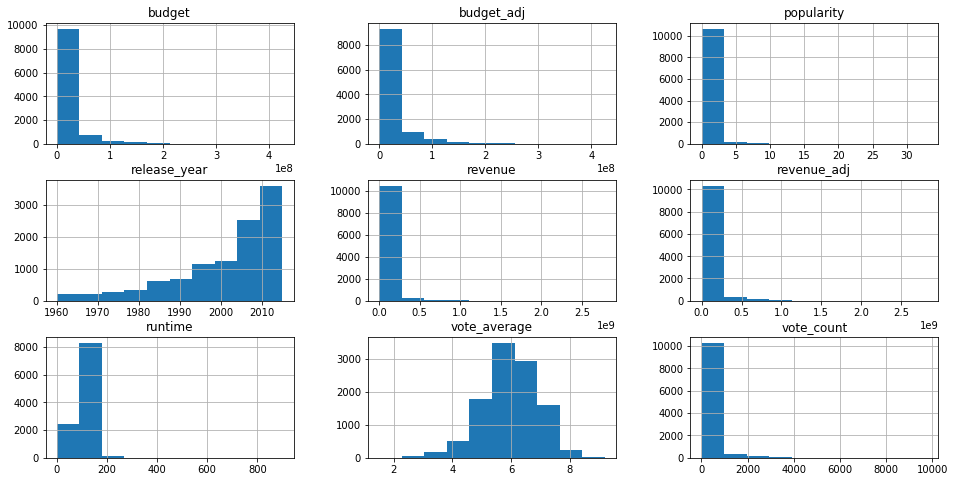

In [8]:
df.hist(figsize=(16,8));

> Conclusions from the histograms:
- Most budget is under 500k$
- There are more recent movies than old ones
- Runtime seems to be lower than 200 minutes for most movies
- Vote average is about 6 points

### Resarch Question 1: What are the most profitable movie absolute and corrected for inflation?

> First sort by revenue and show top rows:

In [9]:
df.sort_values(by=['revenue'], ascending=False).head()

,popularity,budget,revenue,original_title,cast,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
1386,9.432768,237000000,2781505847,Avatar,Sam Worthington|Zoe Saldana|Sigourney Weaver|S...,James Cameron,Enter the World of Pandora.,culture clash|future|space war|space colony|so...,"In the 22nd century, a paraplegic Marine is di...",162,Action|Adventure|Fantasy|Science Fiction,Ingenious Film Partners|Twentieth Century Fox ...,12/10/09,8458,7.1,2009,2.408869e+08,2.827124e+09
3,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,J.J. Abrams,Every generation has a story.,android|spaceship|jedi|space opera|3d,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09
5231,4.355219,200000000,1845034188,Titanic,Kate Winslet|Leonardo DiCaprio|Frances Fisher|...,James Cameron,Nothing on Earth could come between them.,shipwreck|iceberg|ship|panic|titanic,"84 years later, a 101-year-old woman named Ros...",194,Drama|Romance|Thriller,Paramount Pictures|Twentieth Century Fox Film ...,11/18/97,4654,7.3,1997,2.716921e+08,2.506406e+09
4361,7.637767,220000000,1519557910,The Avengers,Robert Downey Jr.|Chris Evans|Mark Ruffalo|Chr...,Joss Whedon,Some assembly required.,new york|shield|marvel comic|comic|superhero,When an unexpected enemy emerges and threatens...,143,Science Fiction|Action|Adventure,Marvel Studios,4/25/12,8903,7.3,2012,2.089437e+08,1.443191e+09
0,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,The park is open.,monster|dna|tyrannosaurus rex|velociraptor|island,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09


> Now select only Title and revenue for plotting a bar graph:

In [10]:
revenue = df.sort_values(by=['revenue'], ascending=False).head()[['original_title','revenue']]
revenue.set_index('original_title')

,revenue
original_title,
Avatar,2781505847
Star Wars: The Force Awakens,2068178225
Titanic,1845034188
The Avengers,1519557910
Jurassic World,1513528810


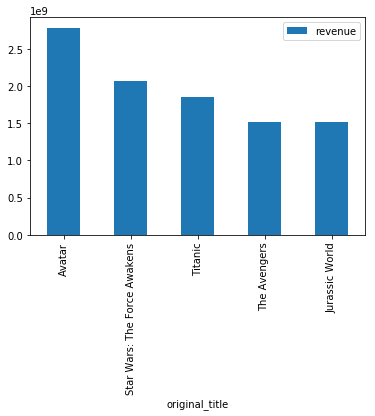

In [11]:
revenue.set_index('original_title').plot.bar();

> This are the movies with most revenue. Avatar and The Force Awakens at the top.

> Now lets compare this with the correction by inflation:

In [12]:
revenue_adj = df.sort_values(by=['revenue_adj'], ascending=False).head()[['original_title','revenue_adj']]
revenue_adj.set_index('original_title')

,revenue_adj
original_title,
Avatar,2.827124e+09
Star Wars,2.789712e+09
Titanic,2.506406e+09
The Exorcist,2.167325e+09
Jaws,1.907006e+09


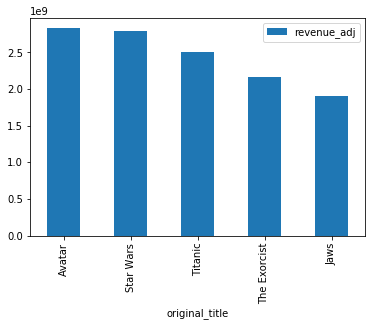

In [13]:
revenue_adj.set_index('original_title').plot.bar();

> Still Avatar at the top but closely followd by Star Wars.

### Research Question 2: Which genres are most produced from year to year?

> What genres are there? To find out we need to separate the data at "|"

In [14]:
df['genres'].str.get_dummies(sep='|').columns

Index(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music',
       'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War',
       'Western'],
      dtype='object')

> Total movies by genre:

In [15]:
genres = df['genres'].str.get_dummies(sep='|').sum()
genres.sort_values(ascending=False)

Drama              4761
Comedy             3793
Thriller           2908
Action             2385
Romance            1712
Horror             1637
Adventure          1471
Crime              1355
Family             1231
Science Fiction    1230
Fantasy             916
Mystery             810
Animation           699
Documentary         520
Music               408
History             334
War                 270
Foreign             188
TV Movie            167
Western             165
dtype: int64

> So overall most movies are labled as drama then comedy.

> But did this change over time? For this to find out, i extract the genre categories with get_dummies. Then combine this data with the movie dataframe.

In [16]:
genres = df['genres'].str.get_dummies(sep='|')
combined = pd.concat([df,genres],axis=1)

> now group by release year and plot the sum of each genre per year:

In [17]:
grouped_year = combined.groupby(['release_year'])

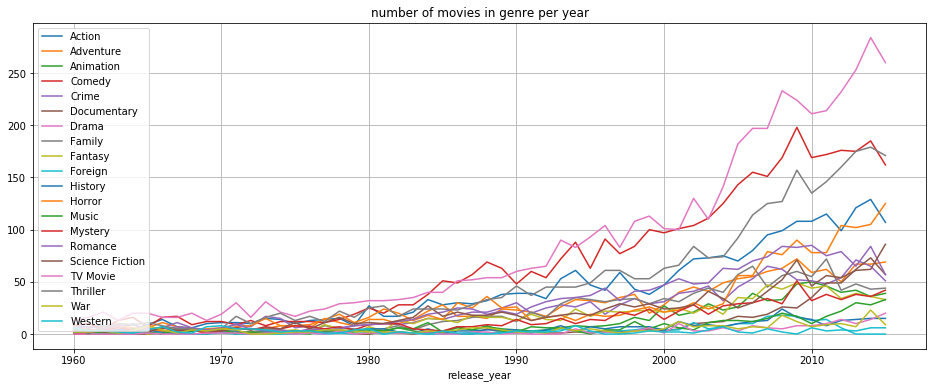

In [18]:
grouped_year.sum()[df['genres'].str.get_dummies(sep='|').columns].plot(figsize=(16,6), grid=True, title='number of movies in genre per year');

> Drama movies are the most released except in the late 80th where comedy was most produced. Seems like comedy movie count is declining for ten years now.

### Research Question 3: Director with most popular films

> Firtst, group the data by director:

In [19]:
grouped_director = df.groupby(['director'])

> Now, sum up the popularity points of the grouped data and sort by popularity. Show only firtst rows.

In [20]:
grouped_director.sum().sort_values(by='popularity',ascending=False).head()

,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
director,,,,,,,,,
Christopher Nolan,61.955206,1005000000,4167548502,1207,41759,74.7,20052,1.014694e+09,4.164262e+09
Steven Spielberg,54.378995,1589950000,9018563772,3900,36735,197.9,57818,2.151770e+09,1.520245e+10
Peter Jackson,49.067904,1326775710,6523244659,1853,31796,91.0,26017,1.375725e+09,7.019848e+09
Ridley Scott,46.213770,1482900000,3649996480,2985,24801,149.0,45970,1.740157e+09,4.219566e+09
Quentin Tarantino,46.059995,350200000,1526668694,1535,27894,80.9,22031,3.621053e+08,1.679526e+09


> So this are the directors with most popularity points.

### Further investigation: Does voting change over time?
> Group data by year and plot the mean of the "vote_average"

In [21]:
voting_grouped_year = df.groupby(['release_year'])

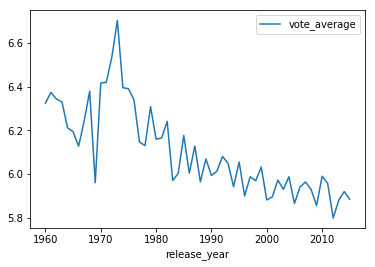

In [22]:
voting_grouped_year.mean()[['vote_average']].plot();

> seems like either movies getting worse, or perhaps people expect more from movies nowadays

> now let us take a look at mean vote count per year:

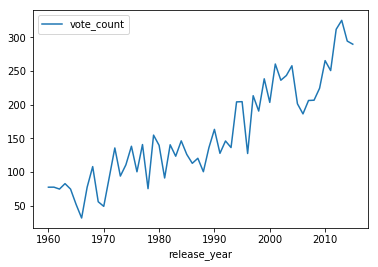

In [23]:
voting_grouped_year.mean()[['vote_count']].plot();

> so vote count per movie more than trippled for newer movies. So maybe this is also influencing the vote average.

<a id='conclusions'></a>
## Conclusions

> After importing and cleaning the data the fist analysis showd there are more new movies than older ones in the dataset. That can have multiple reasons. Maybe the data is incomplete for older movies but probably there are more movies produced now.

> The most profitable movie of all time is Avatar, even if the revenue is corrected by inflation. Followd by a Star Wars movie, but whick one depends if we correct by inflation or not. Titanic is the third most profitable movie regardless of correction for inflation according to this data.

> Drama is the most produced genre in this dataset, only in the late 80th there were more comedy movies released.

> The directors with most popularity points are Christopher Nolan and Steven Spielberg followed by Peter Jackson. A limitation is that it is not clear where the popularity points come from. Maybe the sum of this points is not the best measurement. Looking at the mean would also be possible. I decided to take the sum because this also takes the number of movies each director made into account.

> Further investigation showed that average vote declined over time and vote count increased. This could imply that older movies get not viewed and voted as much as newer ones.

In [24]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0